# Intro

The August 2022 edition of the Tabular Playground Series in an opportunity to help the fictional company Keep It Dry improve its main product Super Soaker. The product is used in factories to absorb spills and leaks.

The company has just completed a large testing study for different product prototypes. Can you use this data to build a model that predicts product failures?



About the Tabular Playground Series
Kaggle competitions are incredibly fun and rewarding, but they can also be intimidating for people who are relatively new in their data science journey. In the past, we've launched many Playground competitions that are more approachable than our Featured competitions and thus, more beginner-friendly.

The goal of these competitions is to provide a fun and approachable-for-anyone tabular dataset to model. These competitions are a great choice for people looking for something in between the Titanic Getting Started competition and the Featured competitions. If you're an established competitions master or grandmaster, these probably won't be much of a challenge for you; thus, we encourage you to avoid saturating the leaderboard.

For each monthly competition, we'll be offering Kaggle Merchandise for the top three teams. And finally, because we want these competitions to be more about learning, we're limiting team sizes to 3 individuals.

Getting Started
For ideas on how to improve your score, check out the Intro to Machine Learning and Intermediate Machine Learning courses on Kaggle Learn.

Good luck and have fun!

[Source](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/overview)

# Import Section

## Packages 

In [555]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Data 

This data represents the results of a large product testing study. For each product_code you are given a number of product attributes (fixed for the code) as well as a number of measurement values for each individual product, representing various lab testing methods. Each product is used in a simulated real-world environment experiment, and and absorbs a certain amount of fluid (loading) to see whether or not it fails.

Your task is to use the data to predict individual product failures of new codes with their individual lab test results.

Files:<br>
- train.csv - the training data, which includes the target failure
- test.csv - the test set; your task is to predict the likelihood each id will experience a failure
- sample_submission.csv - a sample submission file in the correct format

In [582]:
df_train = pd.read_csv('data/train.csv')
df_sample_submission = pd.read_csv('data/sample_submission.csv')
df_test = pd.read_csv('data/test.csv')

# EDA

## sample_submission

The sample submission is an example for the final dataframe which need to be submitted it includes the ID of the sample and the prediction

In [585]:
df_sample_submission.head()

,id,failure
0,26570,0.0
1,26571,0.0
2,26572,0.0
3,26573,0.0
4,26574,0.0


In [586]:
print(f"The sample set includes {df_sample_submission.shape[0]} rows and {df_sample_submission.shape[1]} columns.")

The sample set includes 20775 rows and 2 columns.


In [559]:
df_sample_submission["id"].value_counts().sum()

20775

There are no duplicates for the ID included.

## df_test

### General informaiton

In [587]:
df_test.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [588]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20775 entries, 0 to 20774
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20775 non-null  int64  
 1   product_code    20775 non-null  object 
 2   loading         20552 non-null  float64
 3   attribute_0     20775 non-null  object 
 4   attribute_1     20775 non-null  object 
 5   attribute_2     20775 non-null  int64  
 6   attribute_3     20775 non-null  int64  
 7   measurement_0   20775 non-null  int64  
 8   measurement_1   20775 non-null  int64  
 9   measurement_2   20775 non-null  int64  
 10  measurement_3   20446 non-null  float64
 11  measurement_4   20366 non-null  float64
 12  measurement_5   20267 non-null  float64
 13  measurement_6   20151 non-null  float64
 14  measurement_7   20055 non-null  float64
 15  measurement_8   19929 non-null  float64
 16  measurement_9   19871 non-null  float64
 17  measurement_10  19708 non-null 

The set includes some missing values. 

I will separate the columns between categorical columns and columns which are float distributed:

In [669]:
categorical_columns = ['product_code', 'attribute_0', 'attribute_1','attribute_2', 'attribute_3']
continues_columns = ['loading', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']

### Missing Values

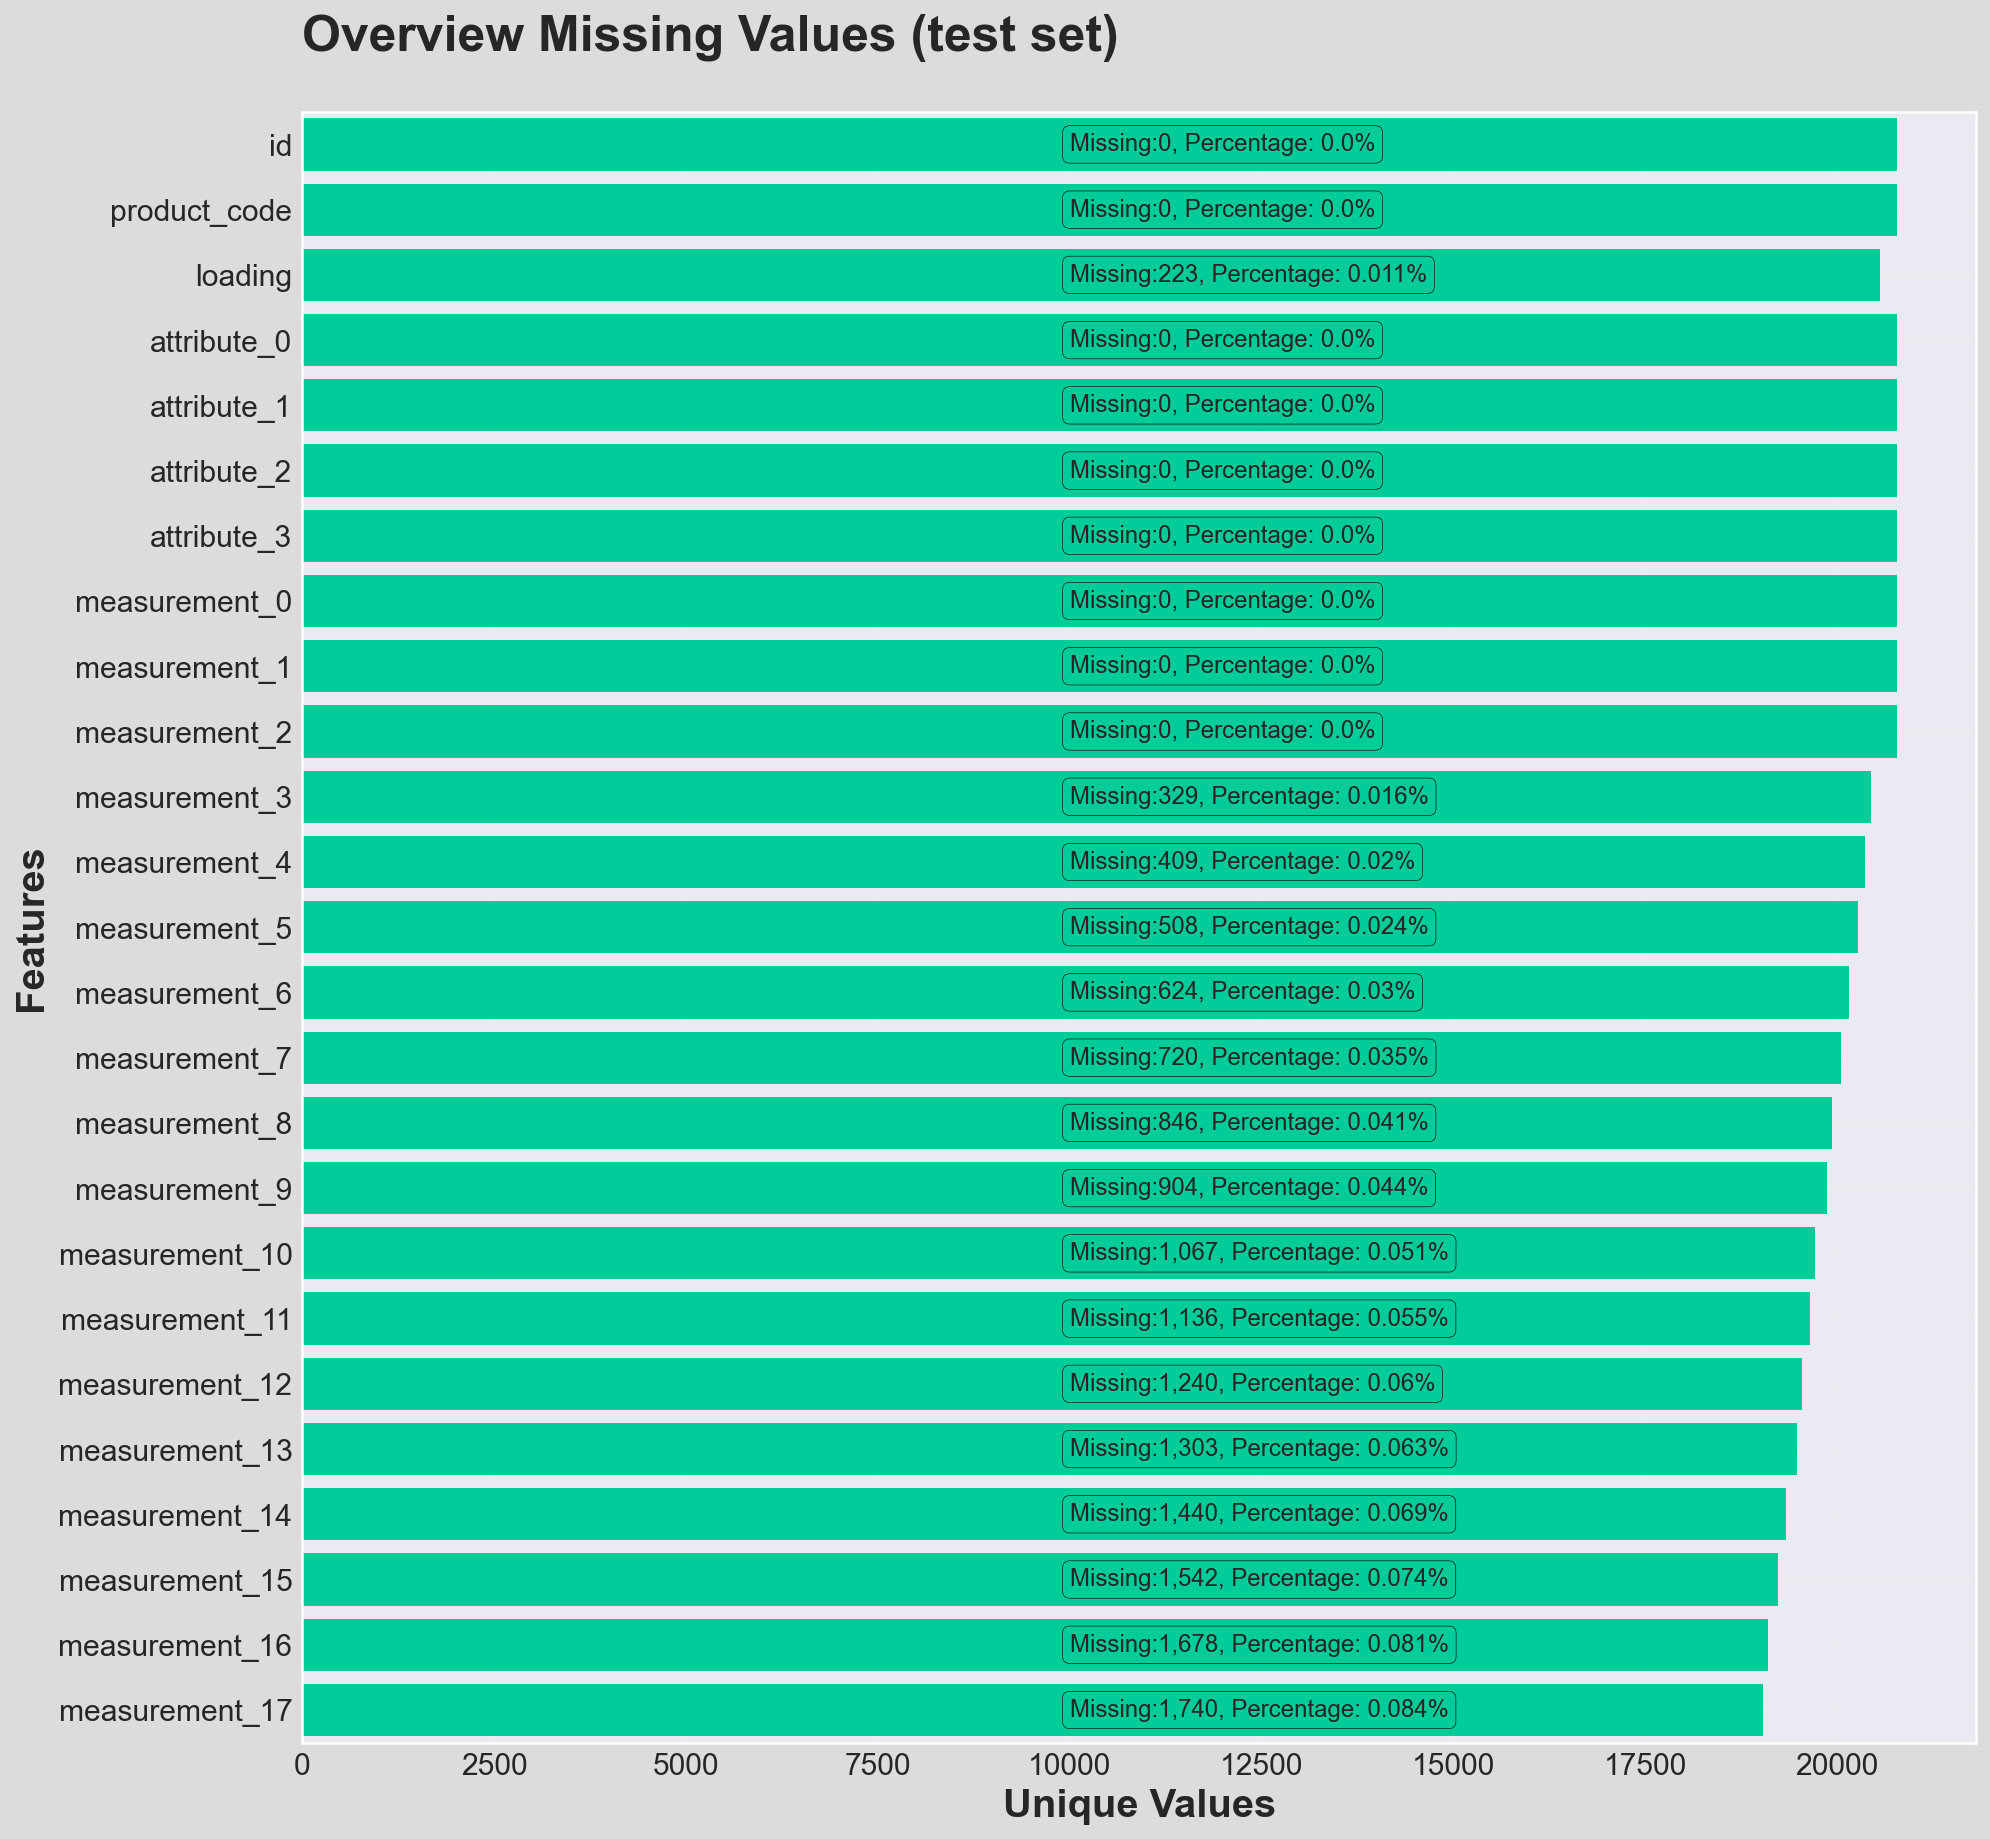

In [590]:
#create dataframe for amount of nan of each column
df_test_nan = pd.DataFrame(df_test.notna().sum()).reset_index(drop=False)
df_test_nan.columns = ['Features', 'Count']
df_test_nan["Percentage"]=unique_values_test["Count"]/df_test.shape[0]

# plotting
plt.figure(figsize=(15, 15), facecolor='#dcdcdc')
chart = sns.barplot(y=df_test_nan['Features'], x=df_test_nan['Count'], 
                      zorder=2, linewidth=0, orient='h', saturation=1, alpha=1, color="#00cc99")

#adjust labels
chart.set_xlabel("Unique Values",fontsize=20, weight='bold')
chart.set_ylabel("Features",fontsize=20, weight='bold')
chart.tick_params(labelsize=15, width=0.5, length=1.5)
# adjust gridlines
chart.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4) 
chart.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4) 
# include Title
chart.text(0, -2, 'Overview Missing Values (test set)', fontsize=25, va='top', weight='bold')
# including data labels
for p in chart.patches:
    value = f'Missing:{df_test.shape[0]-p.get_width():,.0f}, Percentage: {round(1-p.get_width()/df_test.shape[0],3)}%'
    x =  10000
    y = p.get_y() + p.get_height() / 2 
    chart.text(x, y, value, ha='left', va='center', fontsize=12, 
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3)) 
plt.show()

In [591]:
df_test

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20770,47340,I,144.74,material_7,material_5,9,5,0,4,9,...,18.573,11.691,NaN,19.771,11.562,17.246,15.131,15.209,NaN,696.466
20771,47341,I,74.53,material_7,material_5,9,5,4,8,7,...,17.917,10.980,16.027,15.694,13.564,15.494,15.296,13.812,16.501,613.249
20772,47342,I,67.73,material_7,material_5,9,5,10,11,2,...,19.630,10.436,16.137,20.612,11.134,16.519,15.525,14.175,17.728,783.349
20773,47343,I,126.15,material_7,material_5,9,5,8,16,11,...,19.575,12.672,15.422,19.496,9.319,15.817,17.403,16.437,15.179,745.210


For some columns we have missing values. I will replace the missing values with the respective means of these columns. 

In [592]:
numeric_columns = ['id', 'loading','attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']

for col in numeric_columns: 
     df_test[col] = df_test[col].fillna(df_test[col].mean())

### Non Numeric Values

The columns product_code, attribute_0 and attribute_1 are not  numeric values. I will have a closer look to see if we can convert them into numeric values.

#### product_code

In [593]:
df_test["product_code"].unique()

array(['F', 'G', 'H', 'I'], dtype=object)

The column includes alphabetical specifications for a the product code. I will convert this into numeric values. As the Train set also includes alphabetical numbers i will create a dictionary for both sets. 

In [594]:
product_code_dict = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "H": 8, "I": 9}

In [595]:
df_test["product_code"] = [product_code_dict[val] for val in df_test["product_code"]]

#### attribute_0 and attribute_1

In [596]:
print(df_test["attribute_0"].unique())
print(df_test["attribute_1"].unique())

['material_5' 'material_7']
['material_6' 'material_7' 'material_5']


I would like to have just the numeric specification of the material within the columns. 

In [597]:
for col in ['attribute_0', 'attribute_1']:
    df_test[col] = df_test[col].str.replace('material_', "").astype("int64")

## df_train

### General information

In [598]:
df_train.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [599]:
df_train.shape

(26570, 26)

In [600]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26570 non-null  int64  
 1   product_code    26570 non-null  object 
 2   loading         26320 non-null  float64
 3   attribute_0     26570 non-null  object 
 4   attribute_1     26570 non-null  object 
 5   attribute_2     26570 non-null  int64  
 6   attribute_3     26570 non-null  int64  
 7   measurement_0   26570 non-null  int64  
 8   measurement_1   26570 non-null  int64  
 9   measurement_2   26570 non-null  int64  
 10  measurement_3   26189 non-null  float64
 11  measurement_4   26032 non-null  float64
 12  measurement_5   25894 non-null  float64
 13  measurement_6   25774 non-null  float64
 14  measurement_7   25633 non-null  float64
 15  measurement_8   25522 non-null  float64
 16  measurement_9   25343 non-null  float64
 17  measurement_10  25270 non-null 

### Nan values

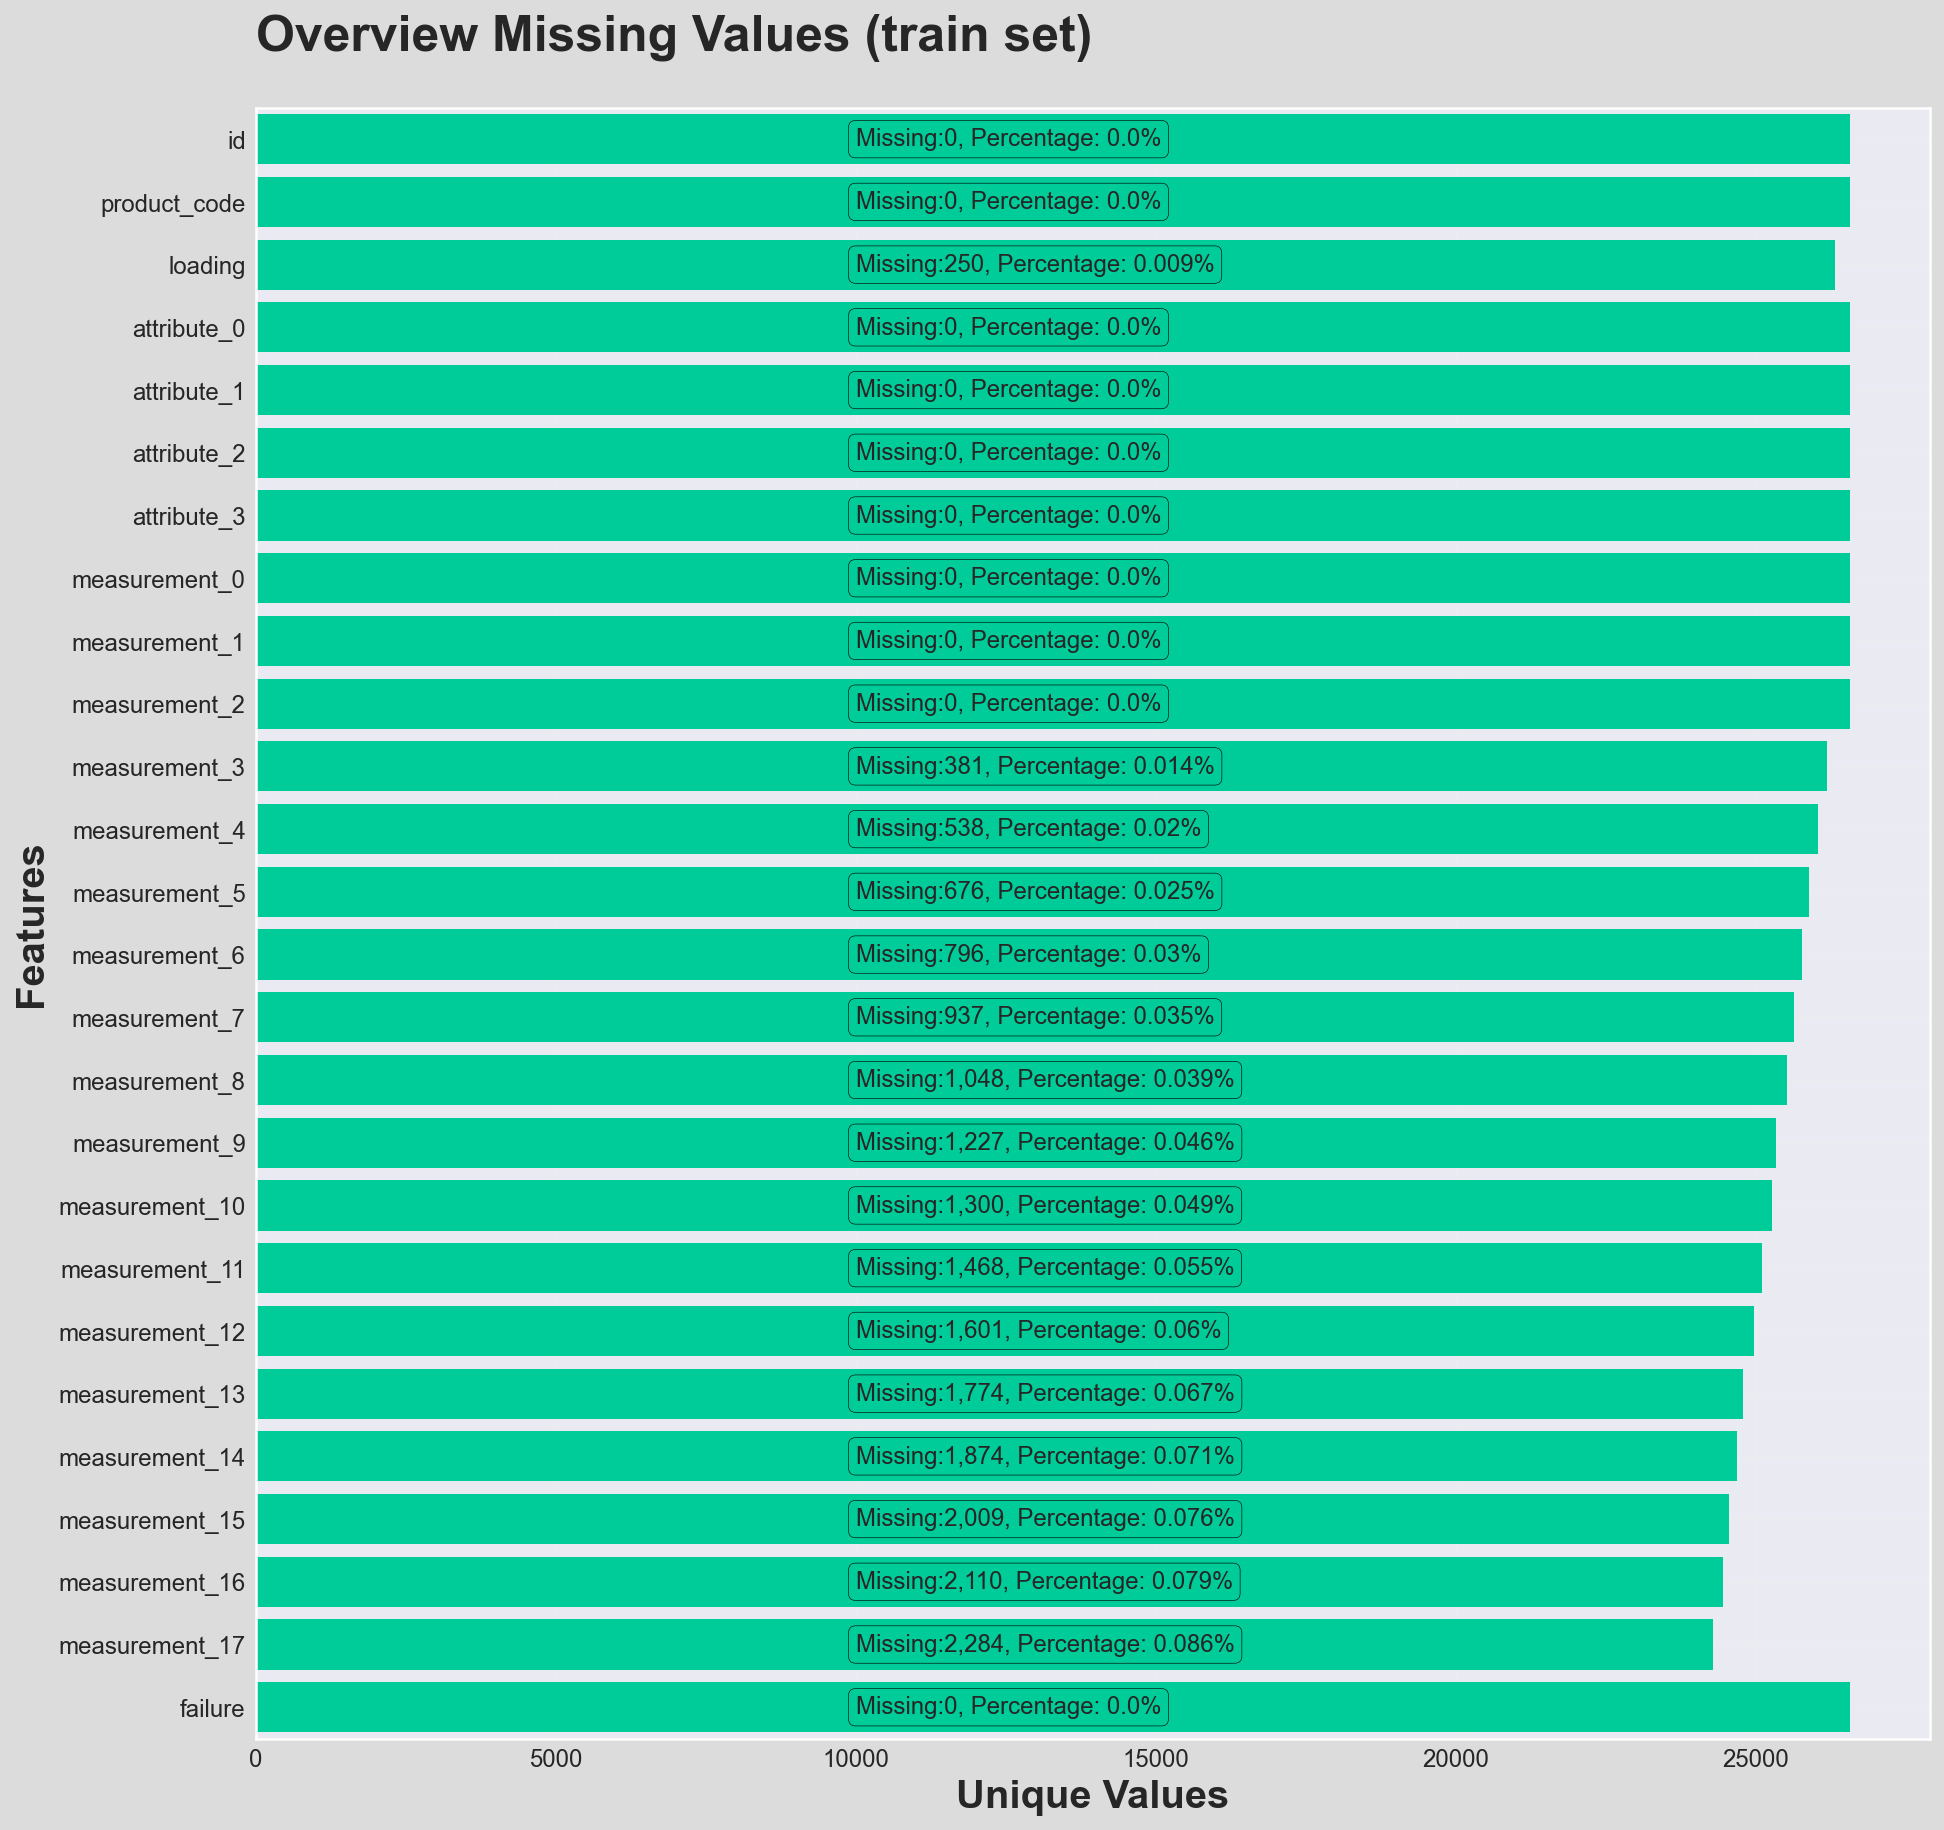

In [601]:
#create dataframe for amount of nan of each column
df_train_nan = pd.DataFrame(df_train.notna().sum()).reset_index(drop=False)
df_train_nan.columns = ['Features', 'Count']
df_train_nan["Percentage"]=unique_values_test["Count"]/df_train.shape[0]

# plotting
plt.figure(figsize=(15, 15), facecolor='#dcdcdc')
chart = sns.barplot(y=df_train_nan['Features'], x=df_train_nan['Count'], 
                      zorder=2, linewidth=0, orient='h', saturation=1, alpha=1, color="#00cc99")

#adjust labels
chart.set_xlabel("Unique Values",fontsize=20, weight='bold')
chart.set_ylabel("Features",fontsize=20, weight='bold')
chart.tick_params(labelsize=12, width=0.5, length=1.5)
# adjust gridlines
chart.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4) 
chart.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4) 
# include Title
chart.text(0, -2, 'Overview Missing Values (train set)', fontsize=25, ha='left', va='top', weight='bold')
# including data labels
for p in chart.patches:
    value = f'Missing:{df_train.shape[0]-p.get_width():,.0f}, Percentage: {round(1-p.get_width()/df_train.shape[0],3)}%'
    x =  10000
    y = p.get_y() + p.get_height() / 2 
    chart.text(x, y, value, ha='left', va='center', fontsize=12, 
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3)) 
plt.show()

For a lot of measurements are nan included. Also the loading column includes some NAN. I will replace the missing values with the respective means of these columns.

In [602]:
for col in numeric_columns: 
     df_train[col] = df_train[col].fillna(df_train[col].mean())

### Baseline

The failure column will be our target column. The baseline looks as below: 

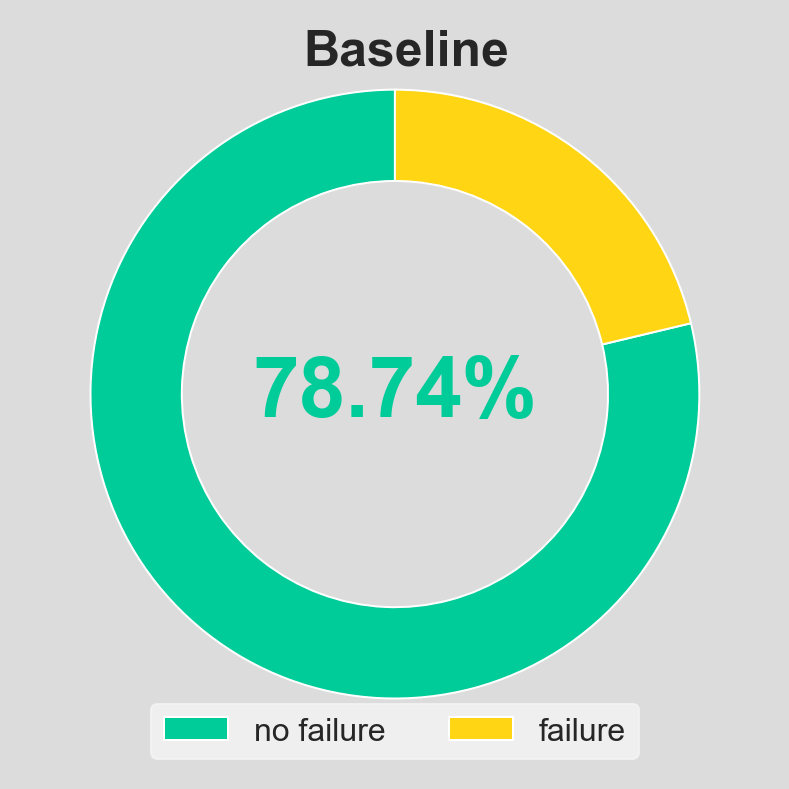

In [603]:
plt.subplots(figsize=(7, 7), facecolor='#dcdcdc')
plt.text(-0.3, 1.2, 'Baseline', fontsize=25, va='top', weight='bold')
plt.pie(df_train.failure.value_counts(), startangle=90, wedgeprops={'width':0.3}, colors=['#00cc99', '#ffd514'] )
plt.text(0, 0, f"{df_train.failure.value_counts()[0] / df_train.failure.count() * 100:.2f}%", ha='center', va='center', fontweight='bold', fontsize=42, color='#00cc99')
plt.legend(["no failure", "failure"], ncol=2, facecolor='#f5f5f5', edgecolor='#f5f5f5', loc='lower center', fontsize=16)
plt.show()

The failure class is imbalanced, failure is a lot less common than success (no failure).

### Non Numeric Values

The columns product_code, attribute_0 and attribute_1 are not  numeric values. I will have a closer look to see if we can convert them into numeric values.

#### product_code

In [604]:
df_train["product_code"].unique()

array(['A', 'B', 'C', 'D', 'E'], dtype=object)

The column includes alphabetical specifications for a the product code. I will use the dictionary created for the test set to convert the values. 

In [605]:
df_train["product_code"] = [product_code_dict[val] for val in df_train["product_code"]]

#### attribute_0 and attribute_1

In [606]:
print(df_train["attribute_0"].unique())
print(df_train["attribute_1"].unique())

['material_7' 'material_5']
['material_8' 'material_5' 'material_6']


I would like to have just the numeric specification of the material within the columns. 

In [607]:
for col in ['attribute_0', 'attribute_1']:
    df_train[col] = df_train[col].str.replace('material_', "").astype("int64")

## Distribution of Data

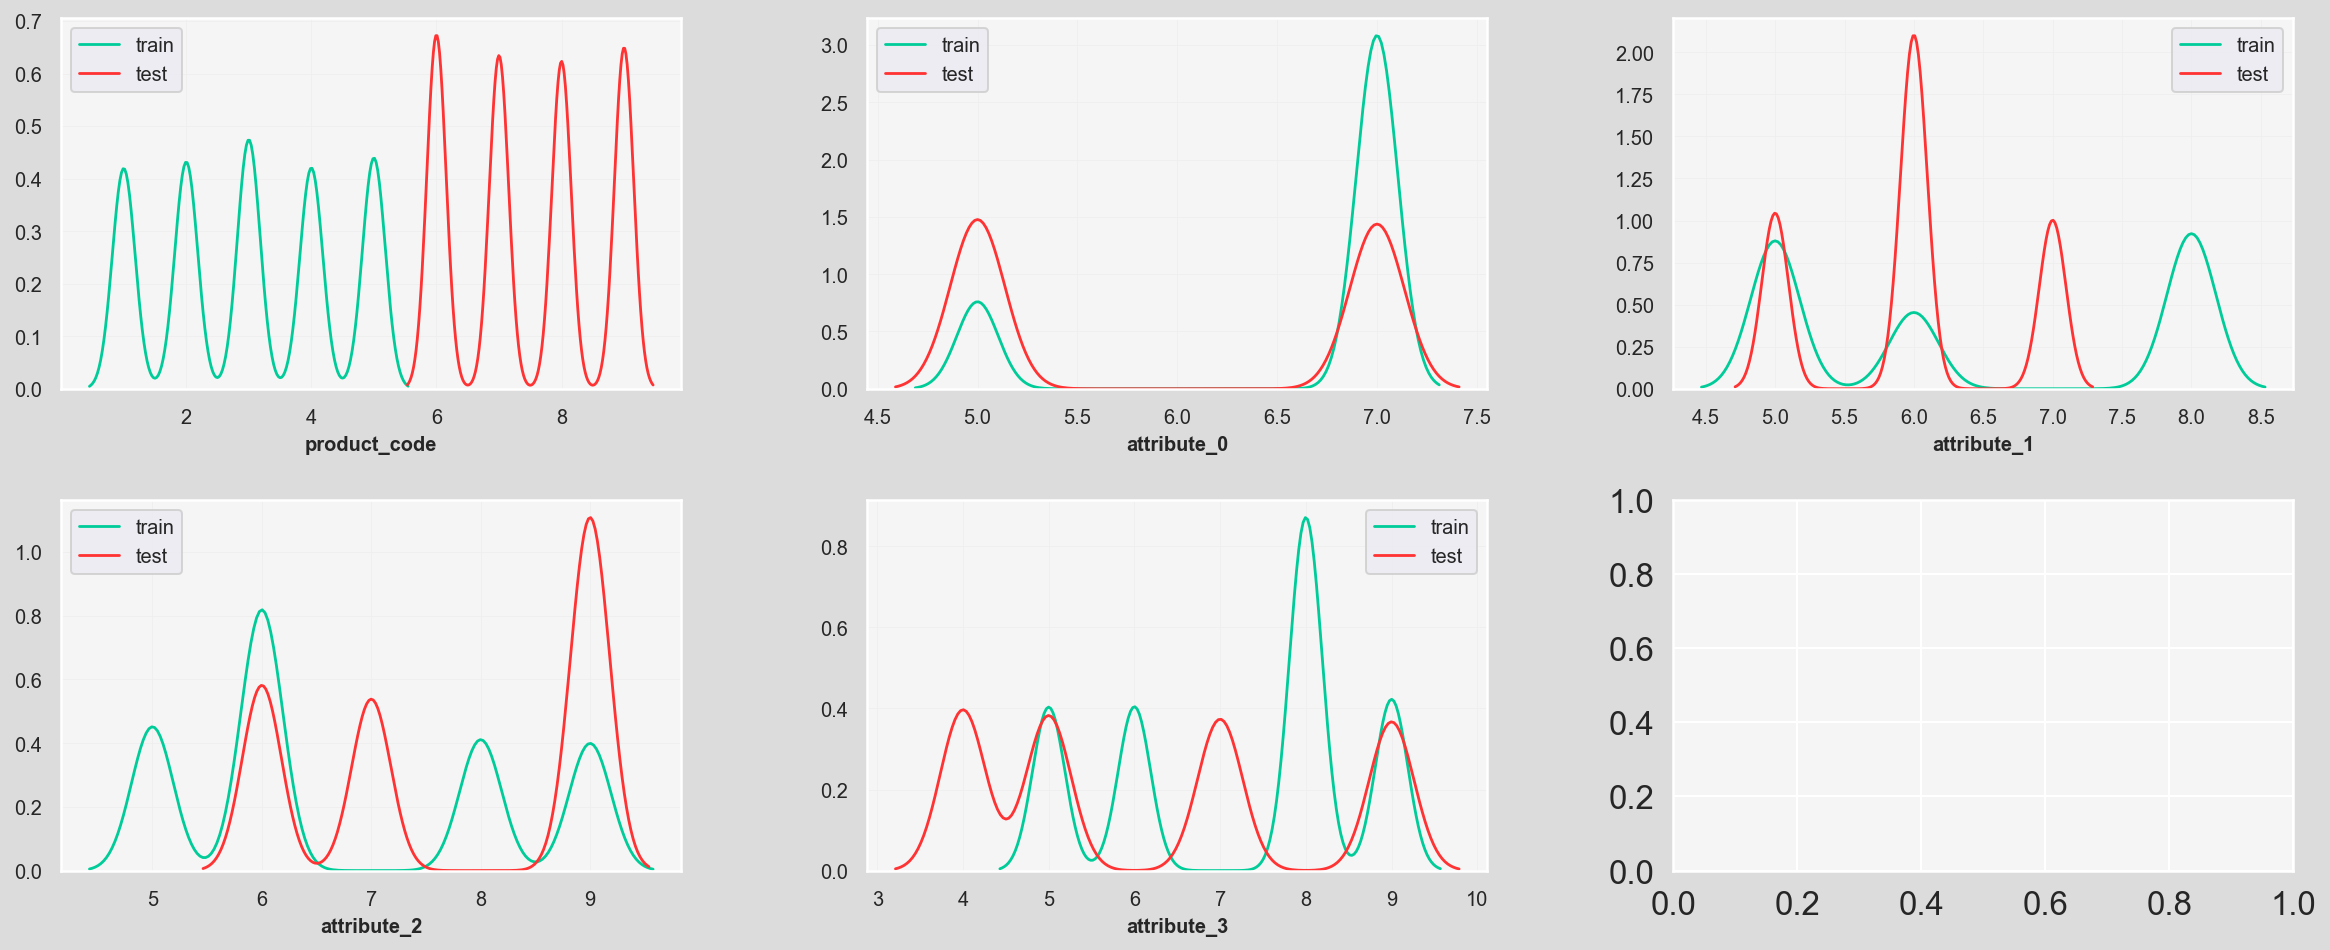

In [670]:
fig = plt.figure(figsize=(20, 30), facecolor='#dcdcdc')
fig.add_gridspec(2, 3)

#create graphs within the grid
pos_no = 0
for row in range(0, 2):
    for col in range(0, 3):
        locals()["ax"+str(pos_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(pos_no)].set_facecolor(background_color)
        for s in ["top","right"]:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        pos_no += 1         
        
# create graph for each column
graph_no = 0
for col in categorical_columns:
        sns.kdeplot(ax=locals()["ax"+str(graph_no)], x=df_train[col], zorder=2, alpha=1, linewidth=1.4, color='#00cc99',legend=True)
        sns.kdeplot(ax=locals()["ax"+str(graph_no)], x=df_test[col], zorder=2, alpha=1, linewidth=1.4, color='#ff3333')
        locals()["ax"+str(graph_no)].grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
        locals()["ax"+str(graph_no)].grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
        locals()["ax"+str(graph_no)].set_ylabel('')
        locals()["ax"+str(graph_no)].set_xlabel(col, fontsize=10, fontweight='bold')
        locals()["ax"+str(graph_no)].tick_params(labelsize=10, width=0.5)
        locals()["ax"+str(graph_no)].xaxis.offsetText.set_fontsize(4)
        locals()["ax"+str(graph_no)].yaxis.offsetText.set_fontsize(4)
        locals()["ax"+str(graph_no)].legend(labels=['train', 'test'], fontsize=10)
        graph_no += 1


plt.show()

We can see that there are some differences between the train and data set.
- The product code between train and test is completely different. 
- the attributes have a different value distribution in train and test. Especially for some attributes we can see that some materials are unique for the train and some are unique for the test set. 

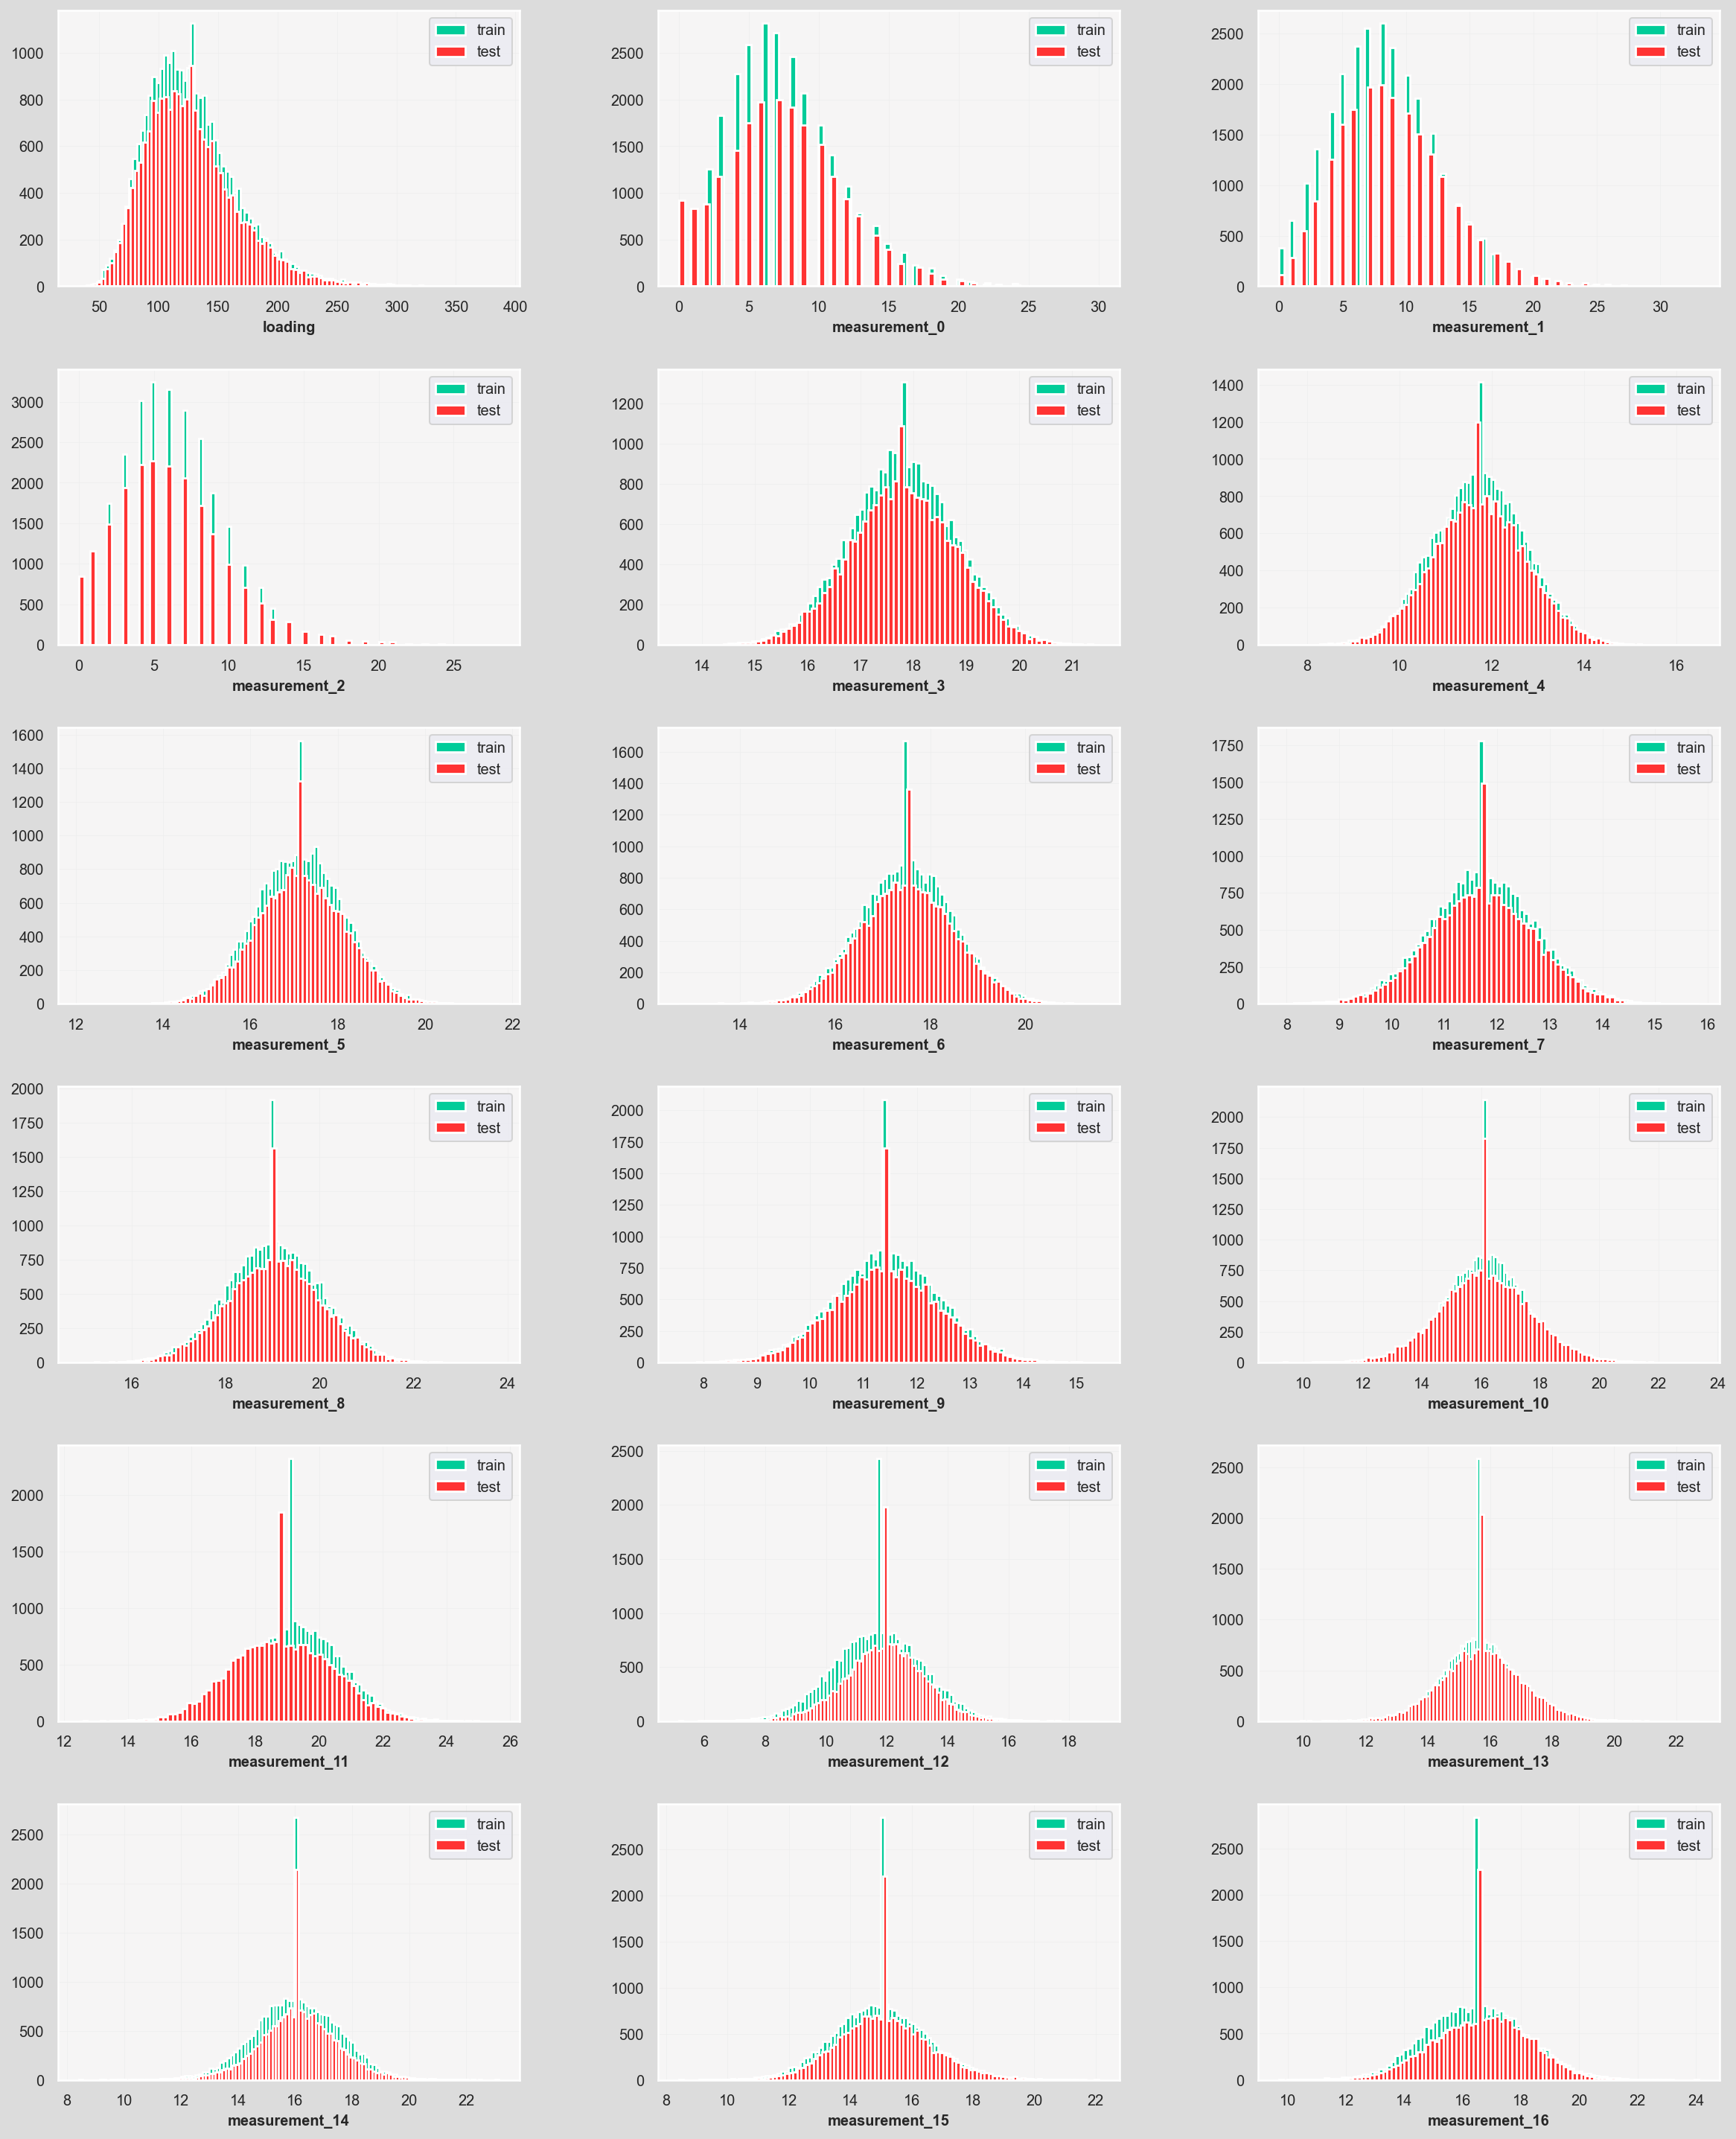

In [673]:
fig = plt.figure(figsize=(20, 30), facecolor='#dcdcdc')
fig.add_gridspec(6, 3)

#create graphs within the grid
pos_no = 0
for row in range(0, 6):
    for col in range(0, 3):
        locals()["ax"+str(pos_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(pos_no)].set_facecolor(background_color)
        for s in ["top","right"]:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        pos_no += 1         
        
# create graph for each column
graph_no = 0
for col in continues_columns:
        sns.histplot(ax=locals()["ax"+str(graph_no)], x=df_train[col], zorder=2, alpha=1, linewidth=1.4, color='#00cc99')
        sns.histplot(ax=locals()["ax"+str(graph_no)], x=df_test[col], zorder=2, alpha=1, linewidth=1.4, color='#ff3333')
        locals()["ax"+str(graph_no)].grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
        locals()["ax"+str(graph_no)].grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
        locals()["ax"+str(graph_no)].set_ylabel('')
        locals()["ax"+str(graph_no)].set_xlabel(col, fontsize=10, fontweight='bold')
        locals()["ax"+str(graph_no)].tick_params(labelsize=10, width=0.5)
        locals()["ax"+str(graph_no)].xaxis.offsetText.set_fontsize(4)
        locals()["ax"+str(graph_no)].yaxis.offsetText.set_fontsize(4)
        locals()["ax"+str(graph_no)].legend(labels=['train', 'test'], fontsize=10)
        graph_no += 1


plt.show()

We can see:
- there are some differences between train and test set. 
- The measurement features are all normally distributed
- The loading feature has a positively skewed distribution
- We can see high peaks for the mean of the values. This is coming from the fact the for the missing values we included the mean. 

##  Correlation

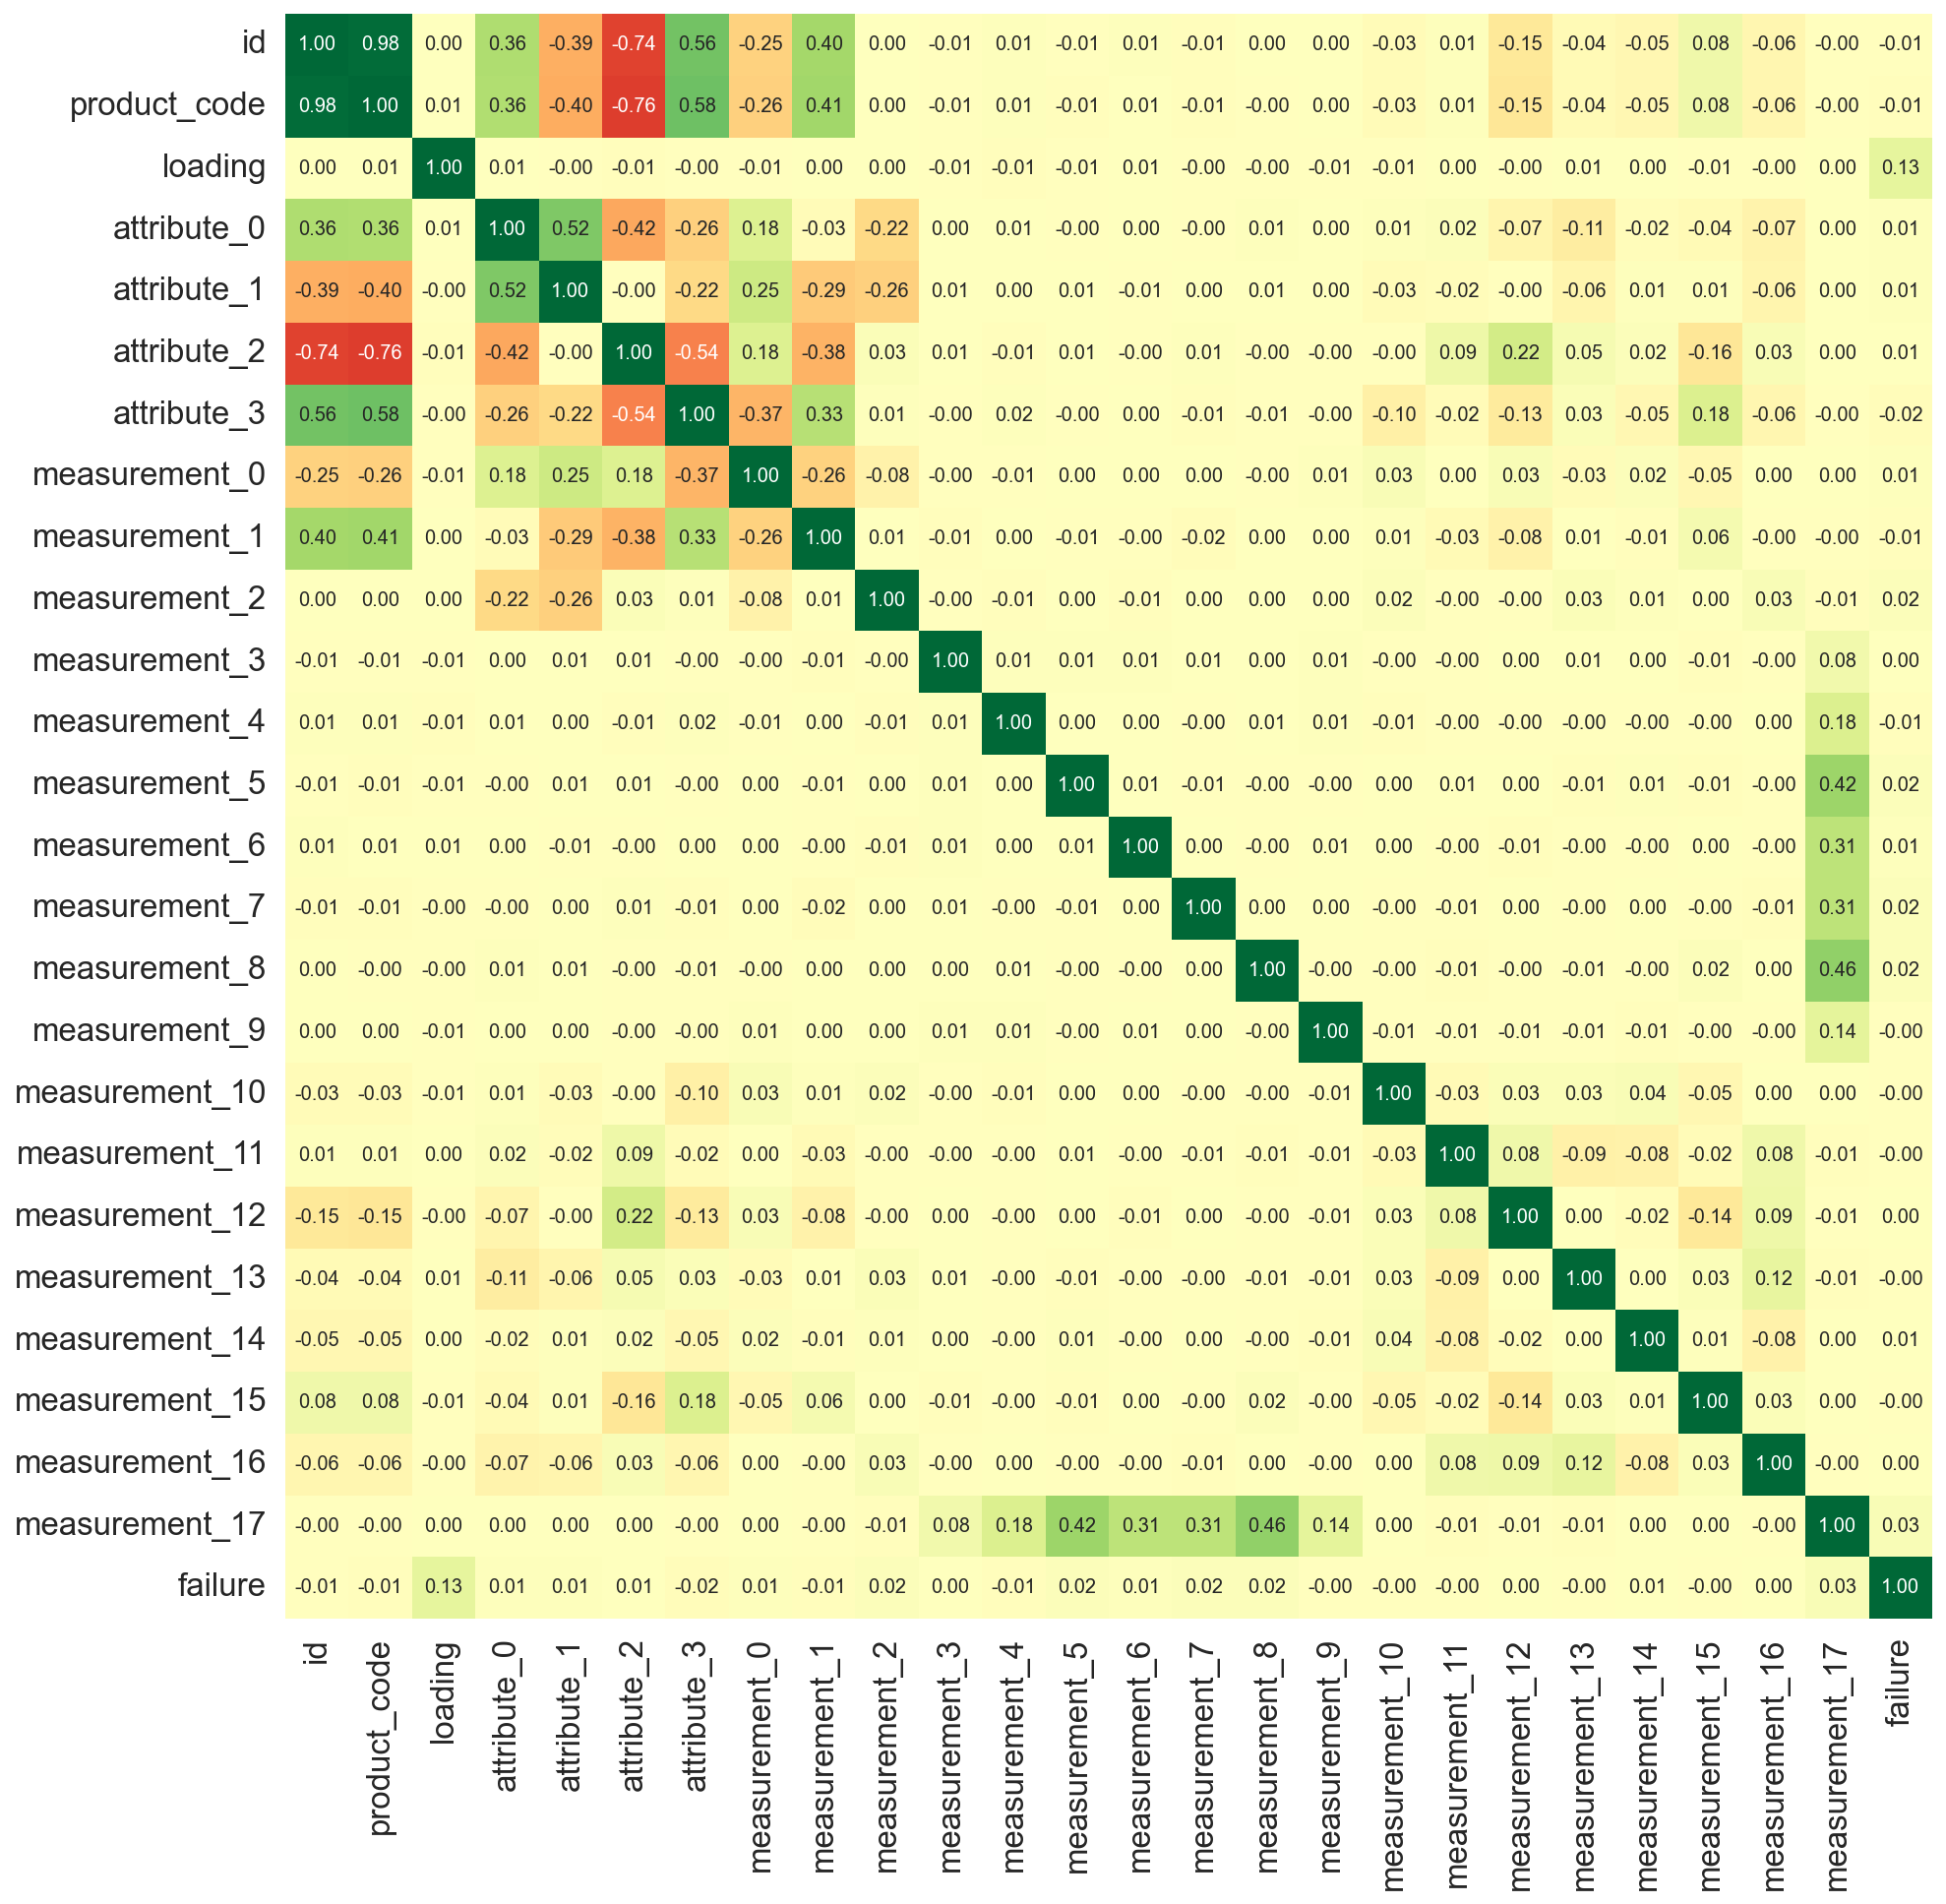

In [581]:
plt.subplots(figsize=(15,15))
sns.heatmap(df_train.corr(),annot=True, cmap="RdYlGn", fmt = '0.2f', vmin=-1, vmax=1, cbar=False);

We can see:
- the leading features shows the highest correlation with the target failure.
- Also we can see that the measurements show some correlations between each other, especially measurement_17

# Modeling

## Defining target and predictors 

In [501]:
y = df_train["failure"]
x = df_train.copy()
x.drop(["failure","id"],axis=1, inplace= True)

In [508]:
x = df_train.copy()

## Train test split

In [510]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

## Standarize the data

In [514]:
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

## Logistic regression with regularization

In [515]:
lr_params = {
    'C' : np.logspace(-3, 3, 7),
    "penalty": ["l1","l2"],
    "solver":['liblinear','saga'],
    "max_iter":[10000]}
lr = LogisticRegression()
lr_gridsearch = GridSearchCV(lr,
                              lr_params,
                              n_jobs=-1, 
                              cv=5, 
                              verbose=1,
                              return_train_score=True)

lr_gridsearch.fit(X_train_std, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'max_iter': [10000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             return_train_score=True, verbose=1)

In [516]:
lr_gridsearch.best_estimator_

LogisticRegression(C=0.01, max_iter=10000, penalty='l1', solver='saga')

In [519]:
best_lr = lr_gridsearch.best_estimator_
print("Training score: ",best_lr.score(X_train_std, y_train))
print("Cross val score: ",cross_val_score(best_lr, X_train_std, y_train, cv=5))
print("Mean Cross val Score: ",cross_val_score(best_lr, X_train_std, y_train, cv=5).mean())
print("Test score: ", best_lr.score(X_test, y_test))

Training score:  0.7839668799397818
Cross val score:  [0.78363123 0.78452129 0.78358033 0.78428605 0.78381557]
Mean Cross val Score:  0.7836845981455749
Test score:  0.19890854347007902


The training score is directly worse than the baseline of 78.74%. I will not further investigate the results from these models. 

## Logistic regression with elastic net regularization 

In [525]:
lr_ela = LogisticRegressionCV(Cs = np.logspace(-3, 3, 7) ,penalty='elasticnet', max_iter=10000, solver='saga', cv=5, 
                               l1_ratios = np.array([.1, .5, .7, .9, .95, .99, 1]), n_jobs=-1)
lr_ela.fit(X_train_std, y_train)
print("Training score: ",lr_ela.score(X_train_std, y_train))
print("Cross val score: ",cross_val_score(lr_ela, X_train_std, y_train, cv=5))
print("Mean Cross val Score: ",cross_val_score(lr_ela, X_train_std, y_train, cv=5).mean())
print("Test score: ", lr_ela.score(X_test, y_test))

Training score:  0.7839668799397818
Cross val score:  [0.78386642 0.78428605 0.78358033 0.78405081 0.78381557]
Mean Cross val Score:  0.7839198369129238
Test score:  0.19890854347007902


The training score is directly worse than the baseline of 78.74%. I will not further investigate the results from these models. 

## K-nearest neighbors

In [529]:
knn_params = {
    'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}
knn = KNeighborsClassifier()
knn_gridsearch = GridSearchCV(knn,
                              knn_params,
                              n_jobs=2, 
                              cv=5, 
                              verbose=1, 
                              return_train_score=True)

knn_gridsearch.fit(X_train_std, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=2,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, verbose=1)

In [531]:
best_knn = knn_gridsearch.best_estimator_
print("Training score: ",best_knn.score(X_train_std, y_train))
print("Cross val score: ",cross_val_score(best_knn, X_train_std, y_train, cv=5))
print("Mean Cross val Score: ",cross_val_score(best_knn, X_train_std, y_train, cv=5).mean())
print("Test score: ", best_knn.score(X_test, y_test))

Training score:  0.7839198343996989
Cross val score:  [0.7841016  0.78405081 0.78405081 0.78405081 0.78381557]
Mean Cross val Score:  0.7840139213550107
Test score:  0.801091456529921


Als for knn the training result is below the baseline of 78.74%. I will not further investigate the results from these models.

## Decision tree classifier 

In [535]:
dt_params = {
    "criterion" : ['gini', 'entropy'],
    "max_depth" : [2,4,6,8,10,12]
}
dt = DecisionTreeClassifier()
dt_gridsearch = GridSearchCV(dt,
                              dt_params,
                              n_jobs=-1, 
                              cv=5, 
                              verbose=1, 
                              return_train_score=True)

dt_gridsearch.fit(X_train_std, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             return_train_score=True, verbose=1)

In [538]:
best_dt = dt_gridsearch.best_estimator_
print("Training score: ",best_dt.score(X_train_std, y_train))
print("Cross val score: ",cross_val_score(best_dt, X_train_std, y_train, cv=5))
print("Mean Cross val Score: ",cross_val_score(best_dt, X_train_std, y_train, cv=5).mean())
print("Test score: ", best_dt.score(X_test, y_test))

Training score:  0.7839668799397818
Cross val score:  [0.78386642 0.78405081 0.78405081 0.78405081 0.78381557]
Mean Cross val Score:  0.7839668846663936
Test score:  0.801091456529921


Als for decision tree classifier the training result is below the baseline of 78.74%. I will not further investigate the results from these models.

In [541]:
X_train.shape

(21256, 24)

## Random Forest Classifier 

In [552]:
rf_params = {
    "n_estimators" : [50,100],
    "criterion" : ["gini", "entropy"],
    "max_depth" : [2,4,6,8,10,12],
    "min_samples_split": [2,3],
    "min_samples_leaf":[1,2,3,4]
}
rf = RandomForestClassifier()
rf_gridsearch = GridSearchCV(rf,
                              rf_params,
                              n_jobs=-1, 
                              cv=5, 
                              verbose=1, 
                              return_train_score=True
                              )

rf_gridsearch.fit(X_train_std, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3],
                         'n_estimators': [50, 100]},
             return_train_score=True, verbose=1)

In [553]:
best_rf = rf_gridsearch.best_estimator_
print("Training score: ",best_rf.score(X_train_std, y_train))
print("Cross val score: ",cross_val_score(best_rf, X_train_std, y_train, cv=5))
print("Mean Cross val Score: ",cross_val_score(best_rf, X_train_std, y_train, cv=5).mean())
print("Test score: ", best_rf.score(X_test, y_test))

Training score:  0.7848136996612721
Cross val score:  [0.78386642 0.78405081 0.78405081 0.78405081 0.78381557]
Mean Cross val Score:  0.7839668846663936
Test score:  0.3471960858110651
